In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jdatetime as jd
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler


Import & Read data






In [ ]:
#در این بخش دیتا ها را می خوانیم و از ردیف 5 شروع می کنیم به خواندن. علت آن این است که هر دیتایی از سایت open-mateo دانلود شود چند ردیف ابتدایی اطلاعات مختصری غیر از داده مورد نیاز در مورد شهر ها است
input_data=pd.read_csv("weather.csv", header=4)
#input_data
#input_data.info()
#input_data.describe()

Data type casting

In [ ]:
#با استفاده از این تابع همه داده ها را بررسی کرده و تا جایی که امکان دارد آن ها را کاهش حجم می دهیم
def auto_data_type(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        min_value = df[col].min()
        max_value = df[col].max()

        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(np.float32)
        elif min_value >= 0:
            if max_value <= 255:
                df[col] = df[col].astype(np.uint8)
            elif max_value <= 65535:
                df[col] = df[col].astype(np.uint16)
            elif max_value <= 4294967295:
                df[col] = df[col].astype(np.uint32)
            else:
                df[col] = df[col].astype(np.uint64)
        else:
            if -128 <= min_value and max_value <= 127:
                df[col] = df[col].astype(np.int8)
            elif -32768 <= min_value and max_value <= 32767:
                df[col] = df[col].astype(np.int16)
            elif -2147483648 <= min_value and max_value <= 2147483647:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
    return df


clean_df=auto_data_type(input_data)

#ستون مربوط به طول روز را در آینده در نمودار همبستگی بررسی خواهیم کرد که آیا در میزان بارش تاثیری دارد یا خیر
clean_df["daylight_duration (s)"]=(clean_df["daylight_duration (s)"]/60).astype(np.uint16)

#به بررسی مقدار حجم کاهش یا فته می پردازیم تا تغییرات را مشاهده کنیم. همان طور که دیده می شود حدود 43 درصد کاهش حجم رخ داده است.
clean_df.info()


Check duplicated and null records


In [ ]:
#clean_df.duplicated()
#clean_df.isnull()

Split data into cities
<p style={text-align=right}>
در دیتایی که مورد بررسی قرار گرفته است، هر شهر با یک آیدی نسبت داده شده است. برا این که بتوانیم تحلیل بهتری داشته باشیم، یک دیکشنری ساخته شده تا در استفاده های بعدی هر شهر مشخص باشد
 </p>


In [ ]:

city_labels = {0: "Tehran", 1: "Qom", 2: "Rasht"}
clean_df["city"] = clean_df["location_id"].map(city_labels)

clean_df_tehran = clean_df[clean_df["location_id"] == 0]
clean_df_qom = clean_df[clean_df["location_id"] == 1]
clean_df_rasht = clean_df[clean_df["location_id"] == 2]

Extract Features
<p style={text-align=right}>
در این بخش چون ستون time در دیتا متشکل از تاریخ میلادی و ساعت است، برای استفاده از آن در تحلیل، آن تاریخ ها را به تاریخ شمسی تبدیل می کنیم.
 از این ویژگی ها برای تحلیل های فصلی، ماهانه و سالانه استفاده می شود. هم چنین میانگین بارش به تفکیک شهر و ماه تا الگو های بارشی را بتوان بررسی کرد.
 </p>


In [ ]:
main_df = clean_df.copy()

main_df["month"] = pd.to_datetime(main_df["time"]).dt.month
main_df["year"] = pd.to_datetime(main_df["time"]).dt.year

main_df["time"] = pd.to_datetime(main_df["time"])

main_df["month_sh"] = main_df["time"].dt.date.apply(
    lambda d: jd.date.fromgregorian(date=d).month
)
monthly_sh = (
    main_df
    .groupby(["city", "month_sh"])["precipitation_sum (mm)"]
    .mean()
    .reset_index()
)

#تابع تبدیل ماه به فصل
def seasons_jalali(date):
    jdate = jd.date.fromgregorian(date=date)
    if jdate.month in [1, 2, 3]:
        return 'spring'
    elif jdate.month in [4, 5, 6]:
        return 'summer'
    elif jdate.month in [7, 8, 9]:
        return 'fall'
    else:
        return 'winter'

main_df["season"] = main_df["time"].map(seasons_jalali)


Data Distribution
<p style={text-align=right}>
در این بخش به بررسی ستون میزان بارش ها در هر سه شهر می پردازیم
 </p>

In [ ]:
cities = main_df["city"].unique()

plt.figure(figsize=(12, 6))
for city in cities:
    city_data = main_df[main_df["city"] == city]["precipitation_sum (mm)"].dropna()
    plt.hist(city_data, bins=50, alpha=0.5, label=city)

plt.title("Comparison of Precipitation Distribution Across Cities")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Number of Days")
plt.legend()
plt.grid(True)
plt.show()
#با استفاده از نمودار هیستوگرام می توان استنباط کرد که چون میزان بارش در شهر رشت زیاد بوده و دو شهر دیگه تقریبا بارش نزدیک به صفر داشتند برای ارزیابی بهتر باید از MinMax scaler استفاده می کنیم

Scaling/Normalization

In [ ]:
df_norm = main_df.copy()
# نرمال‌سازی بارش به صورت جداگانه برای هر شهر
scaler = MinMaxScaler()
df_norm["precip_norm"] = (
    df_norm
    .groupby("city")["precipitation_sum (mm)"]
    .transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).flatten())
)


Remove Outlier Data

In [ ]:
#بر اساس نمودار ، مشاهده شد که شهر رشت دارای چندین داده پرت در بارش روزانه است که می‌تواند نتایج تحلیل را تحت تأثیر قرار دهد.
plt.figure(figsize=(10, 5))
sns.boxplot(data=main_df, x="city", y="precipitation_sum (mm)")
plt.title("Comparison of Precipitation Between Cities")
plt.xlabel("City")
plt.ylabel("Precipitation (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

# برای بررسی دقیق‌تر و نرمال‌سازی داده‌ها، داده‌هایی که خارج از بازه‌ی [میانگین - ۳ × انحراف معیار, میانگین + ۳ × انحراف معیار] قرار داشتند، حذف می کنیم.

rasht_data = main_df[main_df["city"] == "Rasht"]
col = "precipitation_sum (mm)"

mean = rasht_data[col].mean()
std = rasht_data[col].std()

filtered_rasht = rasht_data[(rasht_data[col] >= mean - 3 * std) & (rasht_data[col] <= mean + 3 * std)]

main_df = pd.concat([
    main_df[main_df["city"] != "Rasht"],
    filtered_rasht
])

Data Visualization
<p style={text-align=right}>
در این بخش با استفاده از مصور سازی پی خواهیم برد چه عواملی بر ترتیب بارش ها در شهر ها تاثیر دارد </p>


In [ ]:
# محاسبه میانگین بارش ماهانه هر شهر
monthly_norm = (
    df_norm
    .groupby(["city", "month_sh"])["precip_norm"]
    .mean()
    .reset_index()
)

# رسم نمودار جدید با داده نرمال‌شده برای مشاهده تغییرات
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_norm,
    x="month_sh",
    y="precip_norm",
    hue="city",
    marker="o"
)
plt.title("Monthly Precipitation by City")
plt.xlabel("Month")
plt.ylabel("Precipitation (0–1)mm")
plt.xticks(range(1,13))
plt.legend(title="city")
plt.grid(True)
plt.tight_layout()
plt.show()


#مشاهده می شود که در هر سه شهر بیشتر روزا یا بارونی هست یا خیلی کم بارون می‌بارد، و فقط رشت یک سری روز های پر بارش و حتی برفی دارد


variables = ["precipitation_sum (mm)", "rain_sum (mm)", "snowfall_sum (cm)"]
cities    = main_df["city"].unique()

fig, axes = plt.subplots(len(variables), len(cities), figsize=(12, 9), sharex=False, sharey=False)

for i, var in enumerate(variables):
    for j, city in enumerate(cities):
        ax = axes[i, j]
        subset = main_df[main_df["city"] == city]
        sns.histplot(subset[var], bins=30, kde=True, ax=ax)
        ax.set_title(f"{city} – {var}")
        ax.set_xlabel(var)
        ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()


#از این نمودار می‌توان نتیجه گرفت که رشت در تمام طول سال به‌مراتب پر بارش تر است و اوج بارش آن در اواخر پاییز و زمستان (آبان، آذر، دی و بهمن) رخ می‌دهد، در حالی که قم و تهران در اغلب ماه‌ها تقریباً خشک‌اند و تنها در فصل زمستان (دی تا اسفند) کمی بارش  دارند.



plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_sh,
    x="month_sh",
    y="precipitation_sum (mm)",
    hue="city"
)
plt.title("Average Monthly Precipitation by City")
plt.xlabel("Month")
plt.ylabel("Mean Precipitation (mm)")
plt.xticks(range(1, 13))
plt.legend(title="city")
plt.tight_layout()
plt.show()



### در این نقشه‌ی همبستگی به‌خوبی دیده می‌شود که میانگین دما و میزان بارش رابطه‌ای معکوس دارند؛ یعنی معمولاً وقتی بارش افزایش می‌یابد، دما کمی کاهش می‌یابد. هم چنین دما با طول روز رابطه مثبت و قوی دارد و بیشتر بارش‌ها از نوع باران بوده است.


numeric_cols = [
    "temperature_2m_mean (°C)",
    "precipitation_sum (mm)",
    "rain_sum (mm)",
    "snowfall_sum (cm)",
    "daylight_duration (s)"
]
plt.figure(figsize=(8, 6))
sns.heatmap(main_df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation of Weather Variables")
plt.tight_layout()
plt.show()



#برای تحلیل بهتر روابط بین کمیت ها، نمودار زیر رسم شده است که در آن دمای میانگین، بارش کل، باران، برف و مدت زمان روشنایی روز به تفکیک شهرها  بررسی و نمایش داده شده ‌است. از این نمودار می توان استنباط کرد که در بین هرسه شهر، رابطه  قوی بین دما و مدت روشنایی روز دیده می‌شود. همچنین، مشخص است که در شهر رشت میزان بارش‌ها و باران‌ها بیشتر و داده‌های پرت بیشتری در متغیرهای بارشی دارد. در حالی که تهران و قم بیشتر روزها بدون بارش یا بارش کم دارند.
sns.pairplot(
    data=main_df[numeric_cols + ["city"]],
    hue="city",
    diag_kind="kde",
    plot_kws={"alpha": 0.6}
)
plt.suptitle("Comparison Weather Variables by City", y=1.02)
plt.show()


In [ ]:
##در این نمودار  مشخص است که  دمای میانگین در قم از همه بیشتر و میانه‌ی آن بالاتر است، در حالی که رشت کمترین دامنه‌ی تغییرات دمایی را دارد . در نتیجه  همان طور که قبلا گفته شد دما با بارش رابطه عکس دارد

plt.figure(figsize=(10, 5))
sns.boxplot(data=main_df, x="city", y="temperature_2m_mean (°C)")
plt.title("Comparison of Average Temperature Between Cities")
plt.xlabel("City")
plt.ylabel("Mean Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# در بازه ۲۰۲۰ تا ۲۰۲۴، رشت نوسانات شدید بارشی را تجربه کرده و در سال‌های ۲۰۲۱ و ۲۰۲۳ بیشترین بارش را داشته است، اما در ۲۰۲۴ افت چشمگیری داشته. تهران روندی نسبتاً پایدار و افزایشی تا ۲۰۲۳ داشته و در قم نیز بارندگی در سال ۲۰۲۴ به اوج خود رسیده است.

yearly_precip = (
    main_df
    .groupby(["city", "year"])["precipitation_sum (mm)"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_precip, x="year", y="precipitation_sum (mm)", hue="city", marker="o")
plt.title("Total Annual Precipitation in Cities")
plt.xlabel("Year")
plt.ylabel("Annual Precipitation (mm)")
plt.xticks(ticks=np.arange(yearly_precip["year"].min(), yearly_precip["year"].max() + 1, 1).astype(int))
plt.grid(True)
plt.tight_layout()
plt.show()


# این نمودار نشان می‌دهد که شهر رشت در تمام سال‌ها و فصل‌ها، به‌ویژه در پاییز و زمستان، بارش بسیار بیشتری نسبت به تهران و قم دارد. بارش در تهران نسبتاً متعادل‌تر است و در زمستان افزایش تدریجی دیده می‌شود. قم کم‌باران‌ترین شهر است و عمده بارش آن در پاییز و زمستان رخ می‌دهد.
#

season_order = ["spring", "summer", "fall", "winter"]
cities = ["Tehran", "Qom", "Rasht"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

index = 0
for city in cities:
    city_data = main_df[main_df["city"] == city]

    seasonal = (
        city_data
        .groupby(["year", "season"])["precipitation_sum (mm)"]
        .sum()
        .reset_index()
    )

    sns.barplot(
        data=seasonal,
        x="year",
        y="precipitation_sum (mm)",
        hue="season",
        hue_order=season_order,
        ax=axes[index]
    )

    axes[index].set_title(f"{city} – Seasonal Precipitation")
    axes[index].set_xlabel("Year")
    if index == 0:
        axes[index].set_ylabel("Total Precipitation (mm)")
    else:
        axes[index].set_ylabel("")
    axes[index].grid(True)

    index += 1

plt.show()



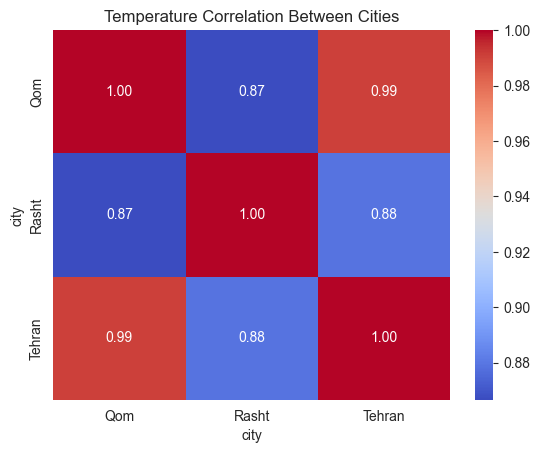

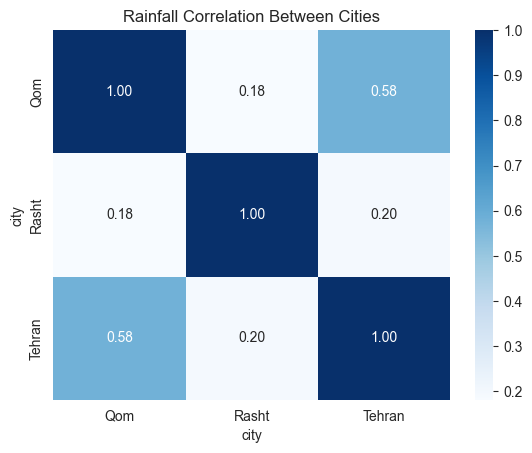

In [52]:
temp = main_df.pivot_table(index="time", columns="city", values="temperature_2m_max (°C)")
rain = main_df.pivot_table(index="time", columns="city", values="precipitation_sum (mm)")
#ارتباط (همبستگی) دما بین همه‌ شهرها بالا است، مخصوصاً تهران و قم
sns.heatmap(temp.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Temperature Correlation Between Cities")
plt.show()
#قم  بارش فقط بین تهران و قم ارتباط نسبتا قوی ای دارد.
sns.heatmap(rain.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Rainfall Correlation Between Cities")
plt.show()


Find Rainfall Timing

In [53]:
#در تأخیر صفر روزه، همبستگی بارش بین تهران و قم بسیار بالا است (۰.۵۷)، که نشان ‌دهنده وقوع هم‌ زمان بارش در این دو شهر است. در تأخیر یک روزه، برخی همبستگی‌ های ضعیف (مانند قم به تهران با ۰.۲۶) دیده می‌شود، اما این مقادیر برای نتیجه ‌گیری قطعی کافی نیستند. با افزایش تأخیر به دو و سه روز، میزان همبستگی به ‌طور قابل ‌توجهی کاهش یافته و پس رابطه زمانی معناداری بین شهرها وجود ندارد.

cities = ["Tehran", "Qom", "Rasht"]
rain_pivot = main_df.pivot_table(index="time", columns="city", values="precipitation_sum (mm)").dropna()

rows = []
for delay_length in range(0, 4):
    for start in cities:
        for end in cities:
            if start != end:
                shifted = rain_pivot[start].shift(delay_length)
                corr = rain_pivot[end].corr(shifted)
                if corr > 0:
                    rows.append([delay_length, start, end, round(corr, 2)])

print(tabulate(rows, headers=["ضریب همبستگی", "مقصد", "مبدا", "تاخیر (روز)"]))

  ضریب همبستگی  مقصد    مبدا      تاخیر (روز)
--------------  ------  ------  -------------
             0  Tehran  Qom              0.57
             0  Tehran  Rasht            0.2
             0  Qom     Tehran           0.57
             0  Qom     Rasht            0.18
             0  Rasht   Tehran           0.2
             0  Rasht   Qom              0.18
             1  Tehran  Qom              0.14
             1  Tehran  Rasht            0.15
             1  Qom     Tehran           0.26
             1  Qom     Rasht            0.11
             1  Rasht   Tehran           0.11
             1  Rasht   Qom              0.12
             2  Tehran  Qom              0.03
             2  Tehran  Rasht            0.06
             2  Qom     Tehran           0.06
             2  Qom     Rasht            0.06
             2  Rasht   Tehran           0.04
             2  Rasht   Qom              0.04
             3  Tehran  Qom              0.05
             3  Tehran  Rasht       

Find common precipitation sequence

In [ ]:
cities = main_df["city"].unique().tolist()

season_names = {
    "spring": "بهار",
    "summer": "تابستان",
    "fall": "پاییز",
    "winter": "زمستان"
}

#در هر روز بررسی می‌ کنیم که اولین شهری که بارش در آن رخ می دهد کدام بوده است، سپس در روزهای بعدی بررسی می کنیم که بارش به چه شهرهای دیگری رفته است.
for season_en, season_fa in season_names.items():
    season_data = main_df[main_df["season"] == season_en]
    season_data = season_data[season_data["precipitation_sum (mm)"] > 0]
    season_data = season_data.sort_values("time")

    events = []

# در هر روز چک می کنیم که کدام شهر بارش داشته است
    for date in season_data["time"].unique():
        daily_data = season_data[season_data["time"] == date]
        for city in daily_data["city"].unique():
            events.append((date, city))

#سپس مرتب سازی می کنیم
    events.sort()

#حال بررسی می کنیم کدام شهر ها بارش داشتند و فقط شهر هایی که قبلا  در یک  توالی نبودند رو بر می داریم. هنگامی که  الگو به سه شهر غیر تکراری برسد آن را ذخیره می کنیم
    all_sequences = []
    for i in range(len(events)):
        visited_cities = [events[i][1]]
        for j in range(i + 1, len(events)):
            if events[j][1] not in visited_cities:
                visited_cities.append(events[j][1])
            if len(visited_cities) == 3:
                all_sequences.append(tuple(visited_cities))
                break

# تعداد تکرار هر الگویی ک ساخته شده است را محاسبه می کنیم
    if all_sequences:
        sequence_count = {}
        for seq in all_sequences:
            sequence_count[seq] = sequence_count.get(seq, 0) + 1

        sorted_sequences = sorted(sequence_count.items(), key=lambda x: x[1], reverse=True)
        most_common = sorted_sequences[0][0]
        most_common_str = " → ".join(most_common)

        table_data = []
        for seq, count in sorted_sequences:
            table_data.append([" → ".join(seq), count])

        table_data.append(["رایج ترین الگو: " + most_common_str, sequence_count[most_common]])

        print(f"\nالگوهای رایج بارش در فصل {season_fa}:\n")
        print(tabulate(table_data, headers=["Sequences", "Number of repetitions"], tablefmt="grid", stralign="center", numalign="center"))
    else:
        print(f"\nدر فصل {season_fa}: الگوی مشخصی یافت نشد")
